In [1]:
# # Requerimientos de librerías:
# !pip install spacy
# !python -m spacy download es_core_news_md

# !pip install transformers
# !pip install transformers scipy ftfy accelerate

# !git clone https://github.com/JorgeSauri/COMSINT.git 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from recomendaciones_comsint import Recomendador

c:\Users\jsaur\anaconda3\envs\ENV1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Con tamaño embeddings 128
- CNN de max 512 kernels (v4)

In [4]:
version = 4

recomendador128 = Recomendador(fuente='recetario_mexicano_small.csv',
                            nutricion = 'nutricion_mejorado.csv',
                            canasta='canasta_basica.csv')

recomendador128.CargarModelo(emb_size=128, version=version)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Modelo Modelos/Modelo_Nut_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.
Modelo Modelos/Modelo_Precios_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.


Generando 10 recetas aleatorias, esto puede tardar varios minutos...


<AxesSubplot:>

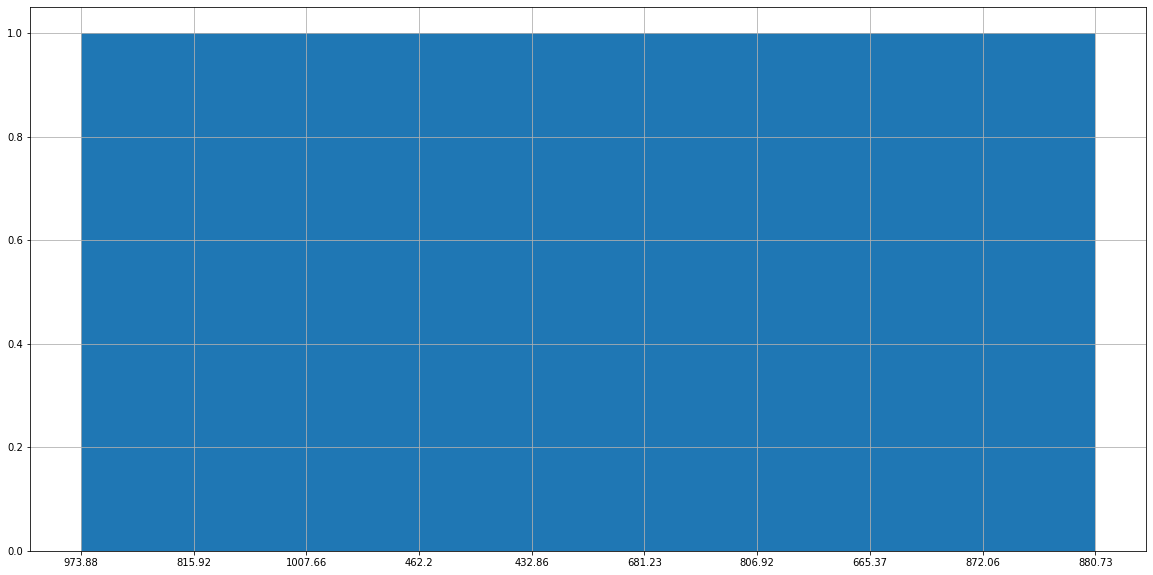

In [5]:
test = recomendador128.generar_dataset_entrenamiento_nut(df_nutricionales='nutricion_mejorado.csv', 
                                                  min_ingredientes=5, max_ingredientes=11,
                                                  min_unidades=1, max_unidades=10,
                                                  min_kcal=300, max_kcal= 1800,
                                                  numero_recetas=10, _INTENTOS=5,
                                                  )

df = pd.DataFrame(test, columns=['ingredientes', 'kcal', 'carbs', 'prot', 'grasas']) 
plt.figure(figsize=(20,10))
df['kcal'].hist()

* Entrenar información nutricional

In [ ]:
recomendador128.NUM_RECETAS = 200
recomendador128.EMB_SIZE = 128
BATCHSIZE = 16
ITER = 3
INITIAL_EPOCH = 0
EPOCHS = recomendador128.NUM_RECETAS // BATCHSIZE
#EPOCHS = 15
LR = 1e-3

Rangos_kcal = [
                (300, 800),
                (801, 1200),
                (1201, 1700)           
                #(500, 1500)              
              ]

Its = []
Valmaes = []
Histories = []
val_mae = 1000
MAX_VAL_MAE = 50
iteracion = 0

#for iteracion in range(ITER):
while val_mae > MAX_VAL_MAE and iteracion<ITER:
  MINU = 1 
  MAXU = 10  
  #INITIAL_EPOCH = 0

  tmp_val_mae = 0
  for ik in range(len(Rangos_kcal)):
    MINK, MAXK = Rangos_kcal[ik]
    print('\nITERACIÓN:', iteracion+1)
    print('VAL_MAE:', val_mae)
    print('min unidades:',MINU, ' max unidades:', MAXU)
    print('min kcal:', MINK, ' max kcal:', MAXK)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    try:
      modelo128, history = recomendador128.EntrenarModelo(df_nutricionales='nutricion_mejorado.csv',
                                    #df_training='recipes_con_info_nutricional.csv',
                                    #df_test='recetas_test.csv', 
                                    #df_val='recetas_val.csv',
                                    learning_rate=LR,
                                    version=version, 
                                    initial_epoch = INITIAL_EPOCH,                             
                                    epochs=INITIAL_EPOCH + EPOCHS, 
                                    batch_size=BATCHSIZE,
                                    kernels=128,                                             
                                    min_ingredientes=5, max_ingredientes=11,                                  
                                    min_unidades=MINU, max_unidades=MAXU,  
                                    min_kcal=MINK, max_kcal= MAXK,                             
                                    save=True, verbose=True)
      INITIAL_EPOCH = history.epoch[-1]      
      tmp_val_mae += float(history.history['val_mae'][-1])           
      Histories.append(history)

    except:
      print('Falló al entrenar en interación', iteracion)
      pass
  
  val_mae = tmp_val_mae / len(Rangos_kcal)
  print('VAL_MAE Promedio:', val_mae)
  iteracion += 1
  Its.append(iteracion)
  Valmaes.append(val_mae)


dfVM = pd.DataFrame({'iteracion':Its, 'val_mae':Valmaes}, columns=['iteracion', 'val_mae'])
dfVM.plot(kind='bar', x='iteracion', y='val_mae')

In [ ]:
for i in range(len(Histories)):
    history = Histories[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')

* Entrenar precios

In [7]:
precios = recomendador128.generar_dataset_entrenamiento_precios(min_ingredientes=5, max_ingredientes=11,
                                                      min_unidades=1, max_unidades=10,
                                                      min_precio = 50, max_precio=150,
                                                      numero_recetas=1000
                                                      )

df = pd.DataFrame(precios, columns=['ingredientes', 'precio'])
df['precio'].describe()

Generando 1000  recetas aleatorias...



count      1000
unique      943
top       51.22
freq          3
Name: precio, dtype: object


ITERACIÓN: 1
Rango de precios: $ 50  y  $ 150
Entrenando desde epoch 0
------------------------------------------

Generando 100  recetas aleatorias...

Calculando vector de características de 100 recetas...


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Epoch 1/12
10/10 [==============================] - 2s 197ms/step - loss: 70.5436 - mae: 70.5436 - val_loss: 60.6531 - val_mae: 60.6531
Epoch 2/12
10/10 [==============================] - 2s 176ms/step - loss: 64.0289 - mae: 64.0289 - val_loss: 51.8087 - val_mae: 51.8087
Epoch 3/12
10/10 [==============================] - 2s 219ms/step - loss: 58.8203 - mae: 58.8203 - val_loss: 45.9931 - val_mae: 45.9931
Epoch 4/12
10/10 [==============================] - 2s 183ms/step - loss: 52.7172 - mae: 52.7172 - val_loss: 41.8683 - val_mae: 41.8683
Epoch 5/12
10/10 [==============================] - 2s 173ms/step - loss: 51.7492 - mae: 51.7492 - val_loss: 38.9047 - val_mae: 38.9047
Epoch 6/12
10/10 [==============================] - 2s 170ms/step - loss: 47.5755 - mae: 47.5755 - val_loss: 36.1396 - val_mae: 36.1396
Epoch 7/12
10/10 [==============================] - 2s 203ms/step - loss: 46.1149 - mae: 46.1149 - val_loss: 34.0909 - val_mae: 34.0909
Epoch 8/12
10/10 [==============================

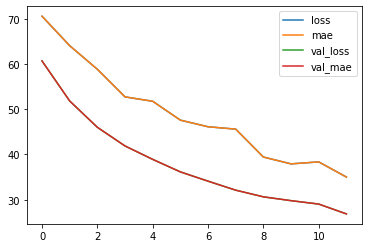

1/1 [==============================] - 0s 259ms/step - loss: 39.4975 - mae: 39.4975
[39.49748611450195, 39.49748611450195]
1/1 [==============================] - 0s 221ms/step
receta 0 precio_prom_por_gramo_true: 120.3 precio_prom_por_gramo_pred: 106.74045  precisión: 88.7 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 53.22 precio_prom_por_gramo_pred: 69.2766  precisión: 76.8 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 68.25 precio_prom_por_gramo_pred: 64.16988  precisión: 94.0 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 64.75 precio_prom_por_gramo_pred: 80.098495  precisión: 80.8 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 106.3 precio_prom_por_gramo_pred: 150.24026  precisión: 70.8 %
-----------------------

100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


Epoch 12/23
10/10 [==============================] - 2s 194ms/step - loss: 207.9569 - mae: 207.9569 - val_loss: 136.4003 - val_mae: 136.4003
Epoch 13/23
10/10 [==============================] - 2s 177ms/step - loss: 133.0997 - mae: 133.0997 - val_loss: 75.8015 - val_mae: 75.8015
Epoch 14/23
10/10 [==============================] - 2s 207ms/step - loss: 108.8229 - mae: 108.8229 - val_loss: 60.2172 - val_mae: 60.2172
Epoch 15/23
10/10 [==============================] - 2s 228ms/step - loss: 80.3918 - mae: 80.3918 - val_loss: 58.3908 - val_mae: 58.3908
Epoch 16/23
10/10 [==============================] - 2s 181ms/step - loss: 74.5006 - mae: 74.5006 - val_loss: 57.5005 - val_mae: 57.5005
Epoch 17/23
10/10 [==============================] - 2s 192ms/step - loss: 75.4769 - mae: 75.4769 - val_loss: 57.6634 - val_mae: 57.6634
Epoch 18/23
10/10 [==============================] - 2s 213ms/step - loss: 73.8390 - mae: 73.8390 - val_loss: 51.5951 - val_mae: 51.5951
Epoch 19/23
10/10 [==============

In [9]:
recomendador128.NUM_RECETAS = 100
recomendador128.EMB_SIZE = 128
BATCHSIZE = 8
ITER = 1
INITIAL_EPOCH = 0
EPOCHS = recomendador128.NUM_RECETAS // BATCHSIZE
MINU = 1 
MAXU = 10  

Rangos_precios = [(50, 150), (151, 350), (351, 550), (551, 750), (751, 1001)]

Histories_precios = []
for iteracion in range(ITER):
    for ip in range(len(Rangos_precios)):
        MINP, MAXP = Rangos_precios[ip]
        print('\nITERACIÓN:', iteracion+1)
        print('Rango de precios: $', MINP, ' y  $', MAXP)
        print('Entrenando desde epoch', INITIAL_EPOCH)
        print('------------------------------------------\n')
        modelo128_precios, history_precios = recomendador128.EntrenarModeloPrecios(
                                        df_precios='lista_precios_profeco_2022.csv',                                   
                                        learning_rate=1e-4,
                                        version=version, 
                                        initial_epoch = INITIAL_EPOCH,                             
                                        epochs=INITIAL_EPOCH + EPOCHS, 
                                        min_ingredientes=5, max_ingredientes=11,                                  
                                        min_unidades=MINU, max_unidades=MAXU,
                                        min_precio=MINP, max_precio=MAXP,
                                        batch_size=BATCHSIZE,
                                        kernels=128,                                                                         
                                        save=True, verbose=True)
        INITIAL_EPOCH = history_precios.epoch[-1]

        Histories_precios.append(history_precios)

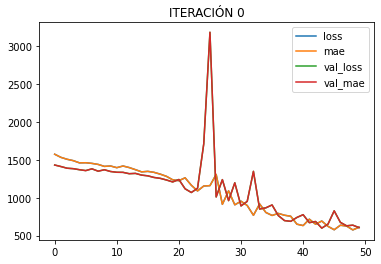

LOSS: 610.884521484375  -- MAE: 610.884521484375  -- VAL_LOSS: 605.876708984375  -- VAL_MAE: 605.876708984375
----------------------------------------------------------


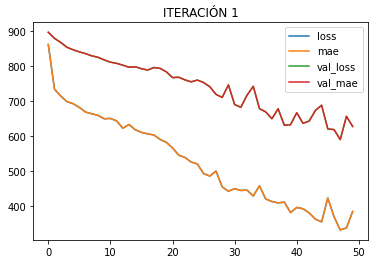

LOSS: 384.781494140625  -- MAE: 384.781494140625  -- VAL_LOSS: 627.9765014648438  -- VAL_MAE: 627.9765014648438
----------------------------------------------------------


In [10]:
for i in range(len(Histories_precios)):
    history = Histories_precios[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')